# U-Net: Predicting Only Human Pose Segmentation Masks

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";  

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np 
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras.preprocessing import image
import cv2
from keras.utils import multi_gpu_model
from scipy import ndimage
from keras.utils import to_categorical
from keras.models import load_model
from keras import losses
from keras import backend as K 

Using TensorFlow backend.


## Create Training and Validation Sets

In [3]:
image_adr = 'SMALL_5K_IMAGES/'
mask_adr = 'SMALL_5K_MASKS/'

#mask_adr = 'SMALL_5K_HEATMAPS/'

#image_adr = 'BIG_18K_IMAGES/'
#mask_adr = 'BIG_18K_MASKS/'

images = sorted(os.listdir(image_adr))
masked = sorted(os.listdir(mask_adr))

In [4]:
print(len(images))
print(len(masked))

5000
5000


In [5]:
np.random.seed(23)
order = np.random.permutation(len(images))
X_train = order[:int(0.8*len(order))]
X_valid = order[int(0.8*len(order)):]
print(len(X_train))
print(len(X_valid))

4000
1000


***

## U-Net Model

In [3]:
smooth = 1e-6

def pixelwise_mse(y_pred, y_true):
    y_pred = K.flatten(y_pred[0,:,:,0])
    y_true = K.flatten(y_true[0,:,:,0])
    return losses.mean_squared_error(y_pred, y_true)

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true[0,:,:,1])
    y_pred_f = K.flatten(y_pred[0,:,:,1])
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def dice_coef_hard(y_pred, y_true):
    y_true_f = K.flatten(y_true[0,:,:,1])
    y_pred_f = K.flatten(np.argmax(y_pred[0,:,:,:], axis=-1).astype('float32'))
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

In [4]:
def create_unet(min_neuron):
    
    inputs = Input((None, None, 3))
    
    conv1 = Conv2D(min_neuron, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(min_neuron, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(min_neuron*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(min_neuron*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    drop2 = Dropout(0.3)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(drop2)
    
    conv3 = Conv2D(min_neuron*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(min_neuron*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    drop3 = Dropout(0.3)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(drop3)
    
    conv4 = Conv2D(min_neuron*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(min_neuron*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.3)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(min_neuron*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(min_neuron*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.3)(conv5)

    up6 = Conv2D(min_neuron*8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(min_neuron*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(min_neuron*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    drop6 = Dropout(0.3)(conv6)
    
    up7 = Conv2D(min_neuron*4, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(min_neuron*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(min_neuron*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    drop7 = Dropout(0.3)(conv7)

    up8 = Conv2D(min_neuron*2, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(min_neuron*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(min_neuron*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    drop8 = Dropout(0.3)(conv8)

    up9 = Conv2D(min_neuron, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(min_neuron, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(min_neuron, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    
    output = Conv2D(2, 1, activation='softmax')(conv9)
    
    model = Model(inputs=inputs, outputs=output)    
    model.compile(optimizer = Adam(lr=2e-5), loss=dice_loss, metrics=[dice_coef])

    return model

In [15]:
def generator(X_data, y_data, order):
    
    samples_per_epoch = len(order)
    number_of_batches = samples_per_epoch
    
    counter=0
    
    while 1:
        
        X_batch = cv2.cvtColor(cv2.imread(image_adr + X_data[order[counter]]), cv2.COLOR_BGR2RGB).astype('float32')
        X_batch /= 255
        
        r = X_batch.shape[0]
        c = X_batch.shape[1]
        r_pad = 0
        c_pad = 0
        
        while r % 16 != 0:
            r_pad += 1
            r += 1
            
        while c % 16 != 0:
            c_pad += 1
            c += 1
            
        X_batch = np.pad(X_batch, ((0, r_pad), (0, c_pad), (0, 0)), mode='constant', constant_values=0)
        X_batch = np.expand_dims(X_batch, axis=0)
        
        y_batch = cv2.imread(mask_adr + y_data[order[counter]], 0).astype('float32')/255*100  # For Heatmaps
        #y_batch = (cv2.imread(mask_adr + y_data[order[counter]], 0) > 200).astype('float32') # For Mask
        y_batch = np.pad(y_batch, ((0, r_pad), (0, c_pad)), mode='constant', constant_values=0)
        
        #y_batch = to_categorical(y_batch, 2) # For Mask
        y_batch = np.expand_dims(y_batch, -1) # For Heatmap
        y_batch = np.expand_dims(y_batch, 0)

        counter += 1
        
        yield X_batch, y_batch

        #restart counter to yeild data in the next epoch as well
        if counter >= number_of_batches:
            counter = 0

In [16]:
model = create_unet(64)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, None, None, 6 1792        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_48 (Conv2D)              (None, None, None, 6 36928       conv2d_47[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, None, None, 6 0           conv2d_48[0][0]                  
__________________________________________________________________________________________________
conv2d_49 

***

## Model Training

### Small Dataset Training

In [19]:
checkpoint = ModelCheckpoint('model-{epoch:03d}-{val_dice_coef:03f}-{val_loss:03f}.h5', verbose=1, 
                             monitor='val_loss', save_best_only=True, mode='auto') 


history = model.fit_generator(generator(images, masked, X_train),
                              epochs=100,
                              steps_per_epoch = len(X_train),
                              validation_data = generator(images, masked, X_valid),
                              validation_steps = len(X_valid),
                              callbacks=[checkpoint])

Epoch 1/100
4000/4000 [==============================] - 238s 60ms/step - loss: 0.2335 - dice_coef: 0.7665 - dice_coef_hard: 0.9209 - val_loss: 0.1594 - val_dice_coef: 0.8406 - val_dice_coef_hard: 0.9514

Epoch 00001: val_loss improved from inf to 0.15944, saving model to model-001-0.840558-0.159442.h5
Epoch 2/100
4000/4000 [==============================] - 234s 59ms/step - loss: 0.1571 - dice_coef: 0.8429 - dice_coef_hard: 0.9519 - val_loss: 0.1458 - val_dice_coef: 0.8542 - val_dice_coef_hard: 0.9544

Epoch 00002: val_loss improved from 0.15944 to 0.14582, saving model to model-002-0.854178-0.145822.h5
Epoch 3/100
4000/4000 [==============================] - 235s 59ms/step - loss: 0.1385 - dice_coef: 0.8615 - dice_coef_hard: 0.9580 - val_loss: 0.1379 - val_dice_coef: 0.8621 - val_dice_coef_hard: 0.9613

Epoch 00003: val_loss improved from 0.14582 to 0.13790, saving model to model-003-0.862100-0.137900.h5
Epoch 4/100
4000/4000 [==============================] - 235s 59ms/step - loss: 

4000/4000 [==============================] - 235s 59ms/step - loss: 0.0376 - dice_coef: 0.9624 - dice_coef_hard: 0.9878 - val_loss: 0.0828 - val_dice_coef: 0.9172 - val_dice_coef_hard: 0.9751

Epoch 00059: val_loss did not improve from 0.08161
Epoch 60/100
4000/4000 [==============================] - 235s 59ms/step - loss: 0.0378 - dice_coef: 0.9622 - dice_coef_hard: 0.9878 - val_loss: 0.0853 - val_dice_coef: 0.9147 - val_dice_coef_hard: 0.9747

Epoch 00060: val_loss did not improve from 0.08161
Epoch 61/100
4000/4000 [==============================] - 235s 59ms/step - loss: 0.0367 - dice_coef: 0.9633 - dice_coef_hard: 0.9881 - val_loss: 0.0832 - val_dice_coef: 0.9168 - val_dice_coef_hard: 0.9748

Epoch 00061: val_loss did not improve from 0.08161
Epoch 62/100
4000/4000 [==============================] - 235s 59ms/step - loss: 0.0367 - dice_coef: 0.9633 - dice_coef_hard: 0.9881 - val_loss: 0.0827 - val_dice_coef: 0.9173 - val_dice_coef_hard: 0.9747

Epoch 00062: val_loss did not improv

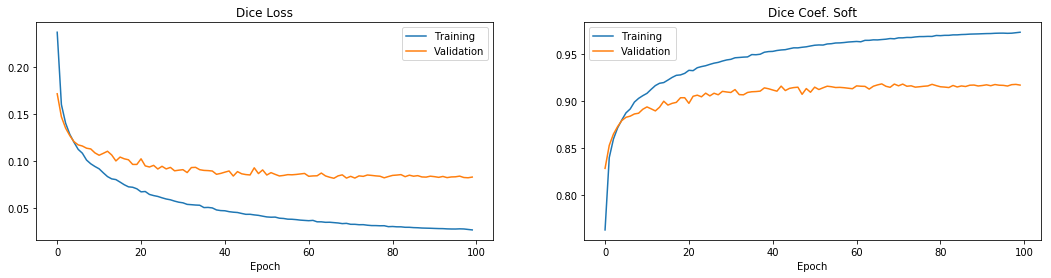

In [12]:
ad = history.history

f, ax = plt.subplots(1,2, figsize=(18,4))

ax[0].plot(ad['loss'], label='Training')
ax[0].plot(ad['val_loss'], label='Validation')
ax[0].set_title('Dice Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend()

ax[1].plot(ad['dice_coef'], label='Training')
ax[1].plot(ad['val_dice_coef'], label='Validation')
ax[1].set_title('Dice Coef. Soft')
ax[1].set_xlabel('Epoch')
ax[1].legend()

### Big Dataset Training

In [393]:
history3 = model.fit_generator(
    generator(images, masked, X_train), 
    epochs=15,
    steps_per_epoch = len(X_train), 
    validation_data = generator(images, masked, X_valid),
    validation_steps = len(X_valid))

Epoch 1/15
14880/14880 [==============================] - 2749s 185ms/step - loss: 0.3069 - dice_coef: 0.6931 - dice_coef_hard: 0.8930 - val_loss: 0.2398 - val_dice_coef: 0.7602 - val_dice_coef_hard: 0.9236
Epoch 2/15
14880/14880 [==============================] - 2478s 167ms/step - loss: 0.2246 - dice_coef: 0.7754 - dice_coef_hard: 0.9327 - val_loss: 0.1986 - val_dice_coef: 0.8014 - val_dice_coef_hard: 0.9405
Epoch 3/15
14880/14880 [==============================] - 2473s 166ms/step - loss: 0.1943 - dice_coef: 0.8057 - dice_coef_hard: 0.9436 - val_loss: 0.1812 - val_dice_coef: 0.8188 - val_dice_coef_hard: 0.9498
Epoch 4/15
14880/14880 [==============================] - 2479s 167ms/step - loss: 0.1734 - dice_coef: 0.8266 - dice_coef_hard: 0.9506 - val_loss: 0.1647 - val_dice_coef: 0.8353 - val_dice_coef_hard: 0.9543
Epoch 5/15
14880/14880 [==============================] - 2481s 167ms/step - loss: 0.1589 - dice_coef: 0.8411 - dice_coef_hard: 0.9552 - val_loss: 0.1625 - val_dice_coef: 0

In [3]:
from keras.utils import plot_model
#plot_model(model1, to_file='model.png')

Using TensorFlow backend.


***

## Model Save

In [24]:
#model.save_weights('15ep_softmax_model_BIG.h5')
model.save('100ep_FULL_dropout_softmax_model_SMALL.h5')

## Model Load

In [5]:
dependencies = {
    'dice_loss': dice_loss,
    'dice_coef_hard': dice_coef_hard,
    'dice_coef': dice_coef
}

#model = keras.models.load_model('30ep_FULL_model_SMALL.h5', custom_objects=dependencies)
model = load_model('model-089-0.919240-0.080760.h5', custom_objects=dependencies)
#model = load_model('100ep_FULL_dropout_softmax_model_SMALL.h5', custom_objects=dependencies)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


***

## Model Performance

### Small Dataset

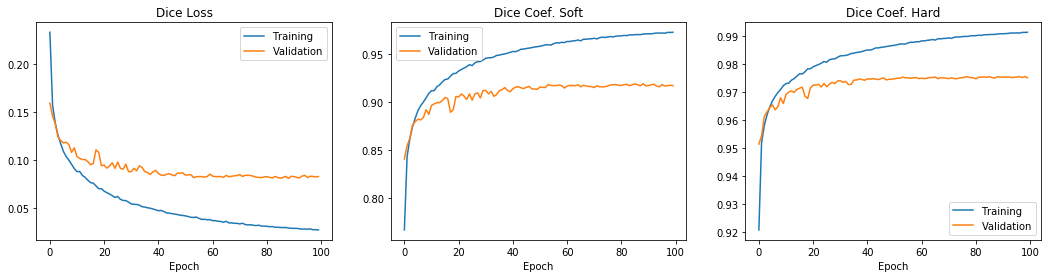

In [21]:
ad = history.history

f, ax = plt.subplots(1,3, figsize=(18,4))

ax[0].plot(ad['loss'], label='Training')
ax[0].plot(ad['val_loss'], label='Validation')
ax[0].set_title('Dice Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend()

ax[1].plot(ad['dice_coef'], label='Training')
ax[1].plot(ad['val_dice_coef'], label='Validation')
ax[1].set_title('Dice Coef. Soft')
ax[1].set_xlabel('Epoch')
ax[1].legend()

ax[2].plot(ad['dice_coef_hard'], label='Training')
ax[2].plot(ad['val_dice_coef_hard'], label='Validation')
ax[2].set_title('Dice Coef. Hard')
ax[2].set_xlabel('Epoch')
ax[2].legend()

### Big Dataset

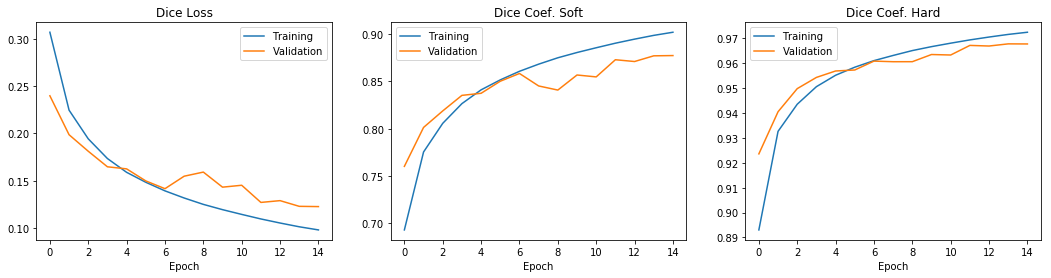

In [396]:
ad = history3.history

f, ax = plt.subplots(1,3, figsize=(18,4))

ax[0].plot(ad['loss'], label='Training')
ax[0].plot(ad['val_loss'], label='Validation')
ax[0].set_title('Dice Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend()

ax[1].plot(ad['dice_coef'], label='Training')
ax[1].plot(ad['val_dice_coef'], label='Validation')
ax[1].set_title('Dice Coef. Soft')
ax[1].set_xlabel('Epoch')
ax[1].legend()

ax[2].plot(ad['dice_coef_hard'], label='Training')
ax[2].plot(ad['val_dice_coef_hard'], label='Validation')
ax[2].set_title('Dice Coef. Hard')
ax[2].set_xlabel('Epoch')
ax[2].legend()

***

## Sample Predictions

### Small Dataset

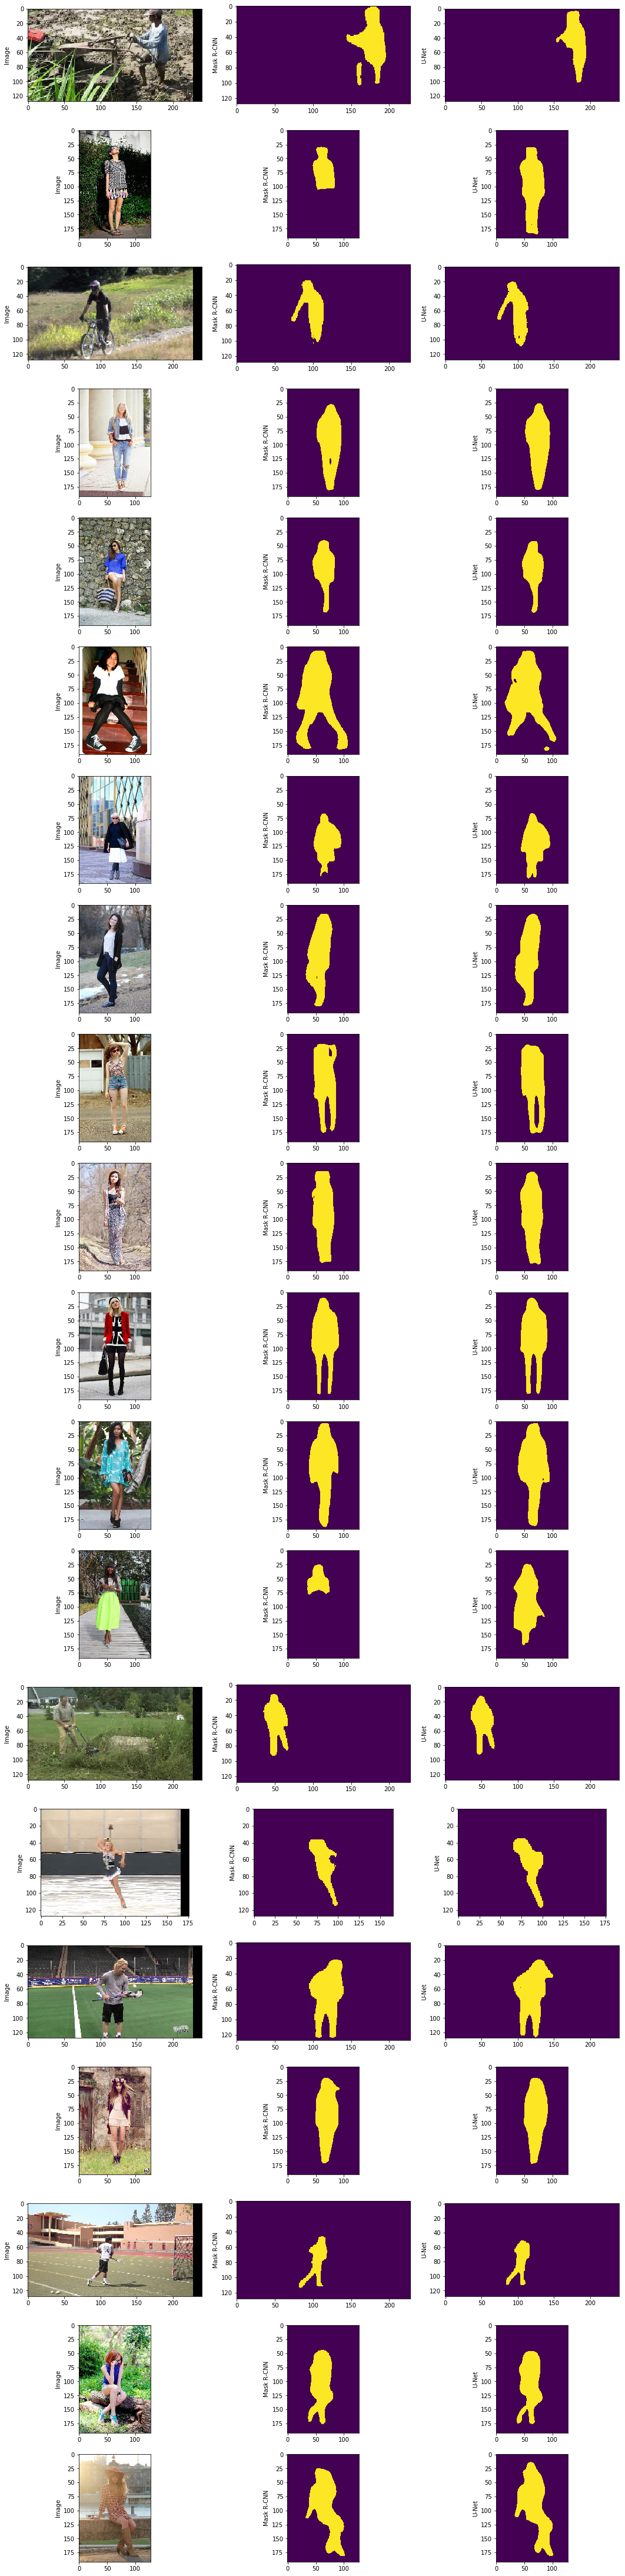

In [36]:
image_list = X_valid[:40]

f, ax = plt.subplots(20,3, figsize=(18,80))
c_ = 0

for i in range(20):
    X_batch = cv2.cvtColor(cv2.imread(image_adr + images[image_list[c_]]), cv2.COLOR_BGR2RGB).astype('float32')
    X_batch /= 255

    r = X_batch.shape[0]
    c = X_batch.shape[1]
    r_pad = 0
    c_pad = 0

    while r % 16 != 0:
        r_pad += 1
        r += 1

    while c % 16 != 0:
        c_pad += 1
        c += 1

    X_batch = np.pad(X_batch, ((0, r_pad), (0, c_pad), (0, 0)), mode='constant', constant_values=0)
    ax[i,0].imshow(X_batch)
    X_batch = np.expand_dims(X_batch, axis=0)

    pred = model1.predict(X_batch)
    pred = np.argmax(pred, axis=3)[0]

    ax[i,1].imshow(cv2.imread(mask_adr + images[image_list[c_]], 0))
    ax[i,2].imshow(pred)
    c_ += 1

for j in range(20):
    _ = ax[j,0].set_ylabel('Image')
    _ = ax[j,1].set_ylabel('Mask R-CNN')
    _ = ax[j,2].set_ylabel('U-Net')

### Big Dataset

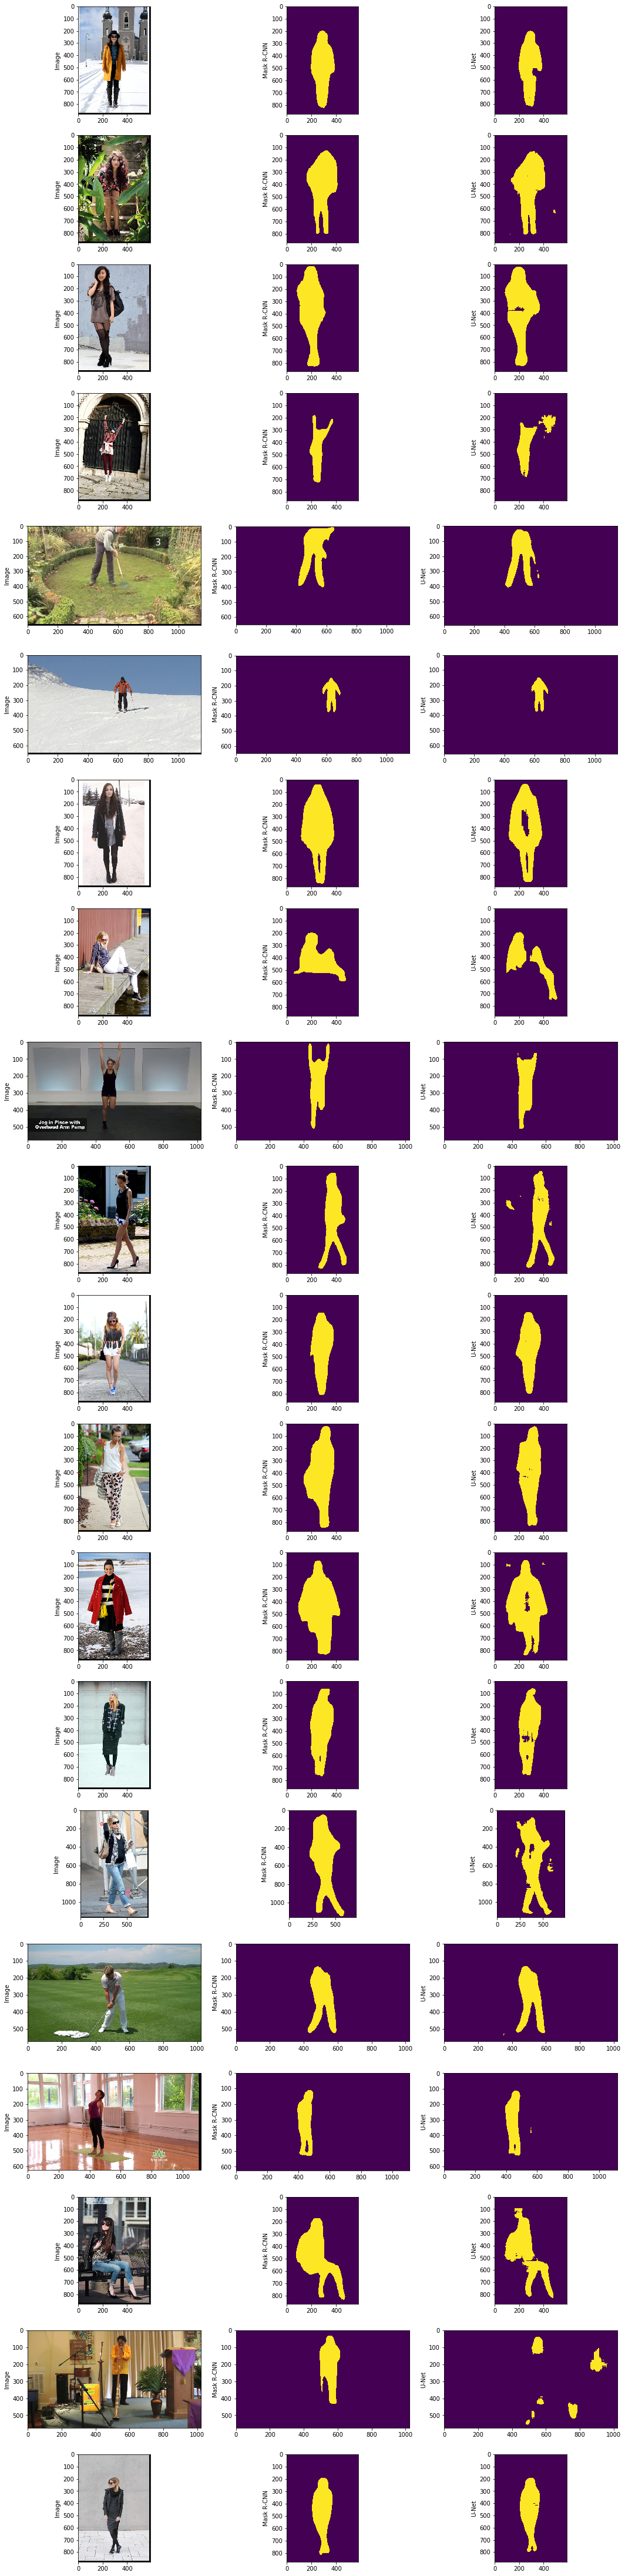

In [397]:
image_list = X_valid[:40]

f, ax = plt.subplots(20,3, figsize=(18,80))
c_ = 0

for i in range(20):
    X_batch = cv2.cvtColor(cv2.imread(image_adr + images[image_list[c_]]), cv2.COLOR_BGR2RGB).astype('float32')
    X_batch /= 255

    r = X_batch.shape[0]
    c = X_batch.shape[1]
    r_pad = 0
    c_pad = 0

    while r % 16 != 0:
        r_pad += 1
        r += 1

    while c % 16 != 0:
        c_pad += 1
        c += 1

    X_batch = np.pad(X_batch, ((0, r_pad), (0, c_pad), (0, 0)), mode='constant', constant_values=0)
    ax[i,0].imshow(X_batch)
    X_batch = np.expand_dims(X_batch, axis=0)

    pred = model.predict(X_batch)
    pred = np.argmax(pred, axis=3)[0]

    ax[i,1].imshow(cv2.imread(mask_adr + images[image_list[c_]], 0))
    ax[i,2].imshow(pred)
    c_ += 1

for j in range(20):
    _ = ax[j,0].set_ylabel('Image')
    _ = ax[j,1].set_ylabel('Mask R-CNN')
    _ = ax[j,2].set_ylabel('U-Net')

## Comparison of U-Net, H-Net and Real Number of Foreground Pixels in Validation Set Predictions



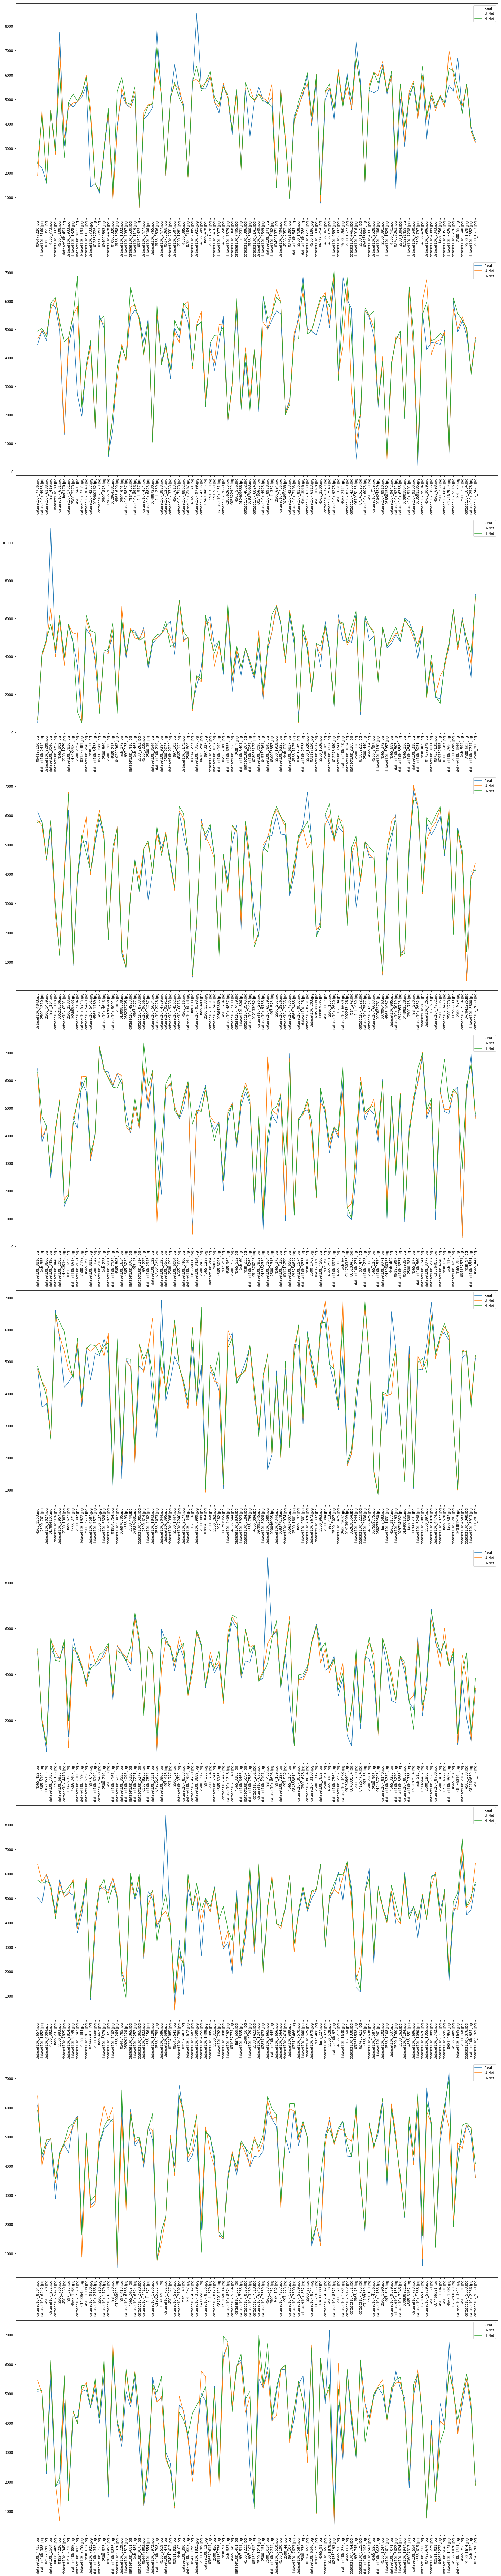

In [49]:
f, ax = plt.subplots(10,1, figsize=(25,135))

for i in range(10):
    ax[i].plot(real[i*100:(i+1)*100], label='Real')
    ax[i].plot(unet[i*100:(i+1)*100], label='U-Net')
    ax[i].plot(sum_hnet[i*100:(i+1)*100], label='H-Net')
    ax[i].set_xticks(range(100))
    x_ticks_labels = list(np.array(images)[X_valid[i*100:(i+1)*100]])
    ax[i].set_xticklabels(x_ticks_labels, rotation='vertical')
    ax[i].legend()